<a href="https://colab.research.google.com/github/arminwitte/llsi/blob/main/notebooks/example_diss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

# Install llsi and statsmodels if running in Google Colab
if "google.colab" in sys.modules:
    !pip install llsi statsmodels


In [2]:
!wget https://raw.githubusercontent.com/arminwitte/llsi/80150bc50595bbd6ba2e06b351b0c439b023c867/data/heated_wire_data.npy

Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [3]:
# %cd ..

In [4]:
!pip install -e .

Obtaining file:///C:/Users/letsg/git/llsi/notebooks


ERROR: file:///C:/Users/letsg/git/llsi/notebooks does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [5]:
import matplotlib.pyplot as plt
import numpy as np

import llsi

c:\Users\letsg\git\llsi\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import os
import numpy as np
import requests

# Load data
data_path = os.path.join("..", "data", "heated_wire_data.npy")
if not os.path.exists(data_path):
    url = "https://github.com/zashwood/llsi/raw/main/data/heated_wire_data.npy"
    print(f"Downloading data from {url}...")
    response = requests.get(url)
    with open("heated_wire_data.npy", "wb") as f:
        f.write(response.content)
    data_path = "heated_wire_data.npy"

d = np.load(data_path)
t = d[:, 0]
Re = d[:, 1]
Nu = d[:, 2]

u = Re.reshape(-1, 1).copy()  # Input: voltage (Reynolds number)
y = Nu.reshape(-1, 1).copy()  # Output: temperature (Nusselt number)

# Center data
u -= np.mean(u)
y -= np.mean(y)

# Split into train and test
n_train = 800
u_train, y_train = u[:n_train], y[:n_train]
u_test, y_test = u[n_train:], y[n_train:]


In [7]:
data = llsi.SysIdData(t=t, Re=Re, Nu=Nu)
data.equidistant(305002)
print(data.time().shape)
data.center()
data.downsample(18)
data.lowpass(1, 10)
data, test_set = data.split(0.8)
data.crop(start=1000)
data.center()
print(1 / data.Ts)

(305002,)
4319.992477518855


c:\Users\letsg\git\llsi\.venv\Lib\site-packages\scipy\optimize\_optimize.py:2542: RuntimeWarning: overflow encountered in scalar multiply
  tmp2 = 2.0 * (tmp2 - tmp1)


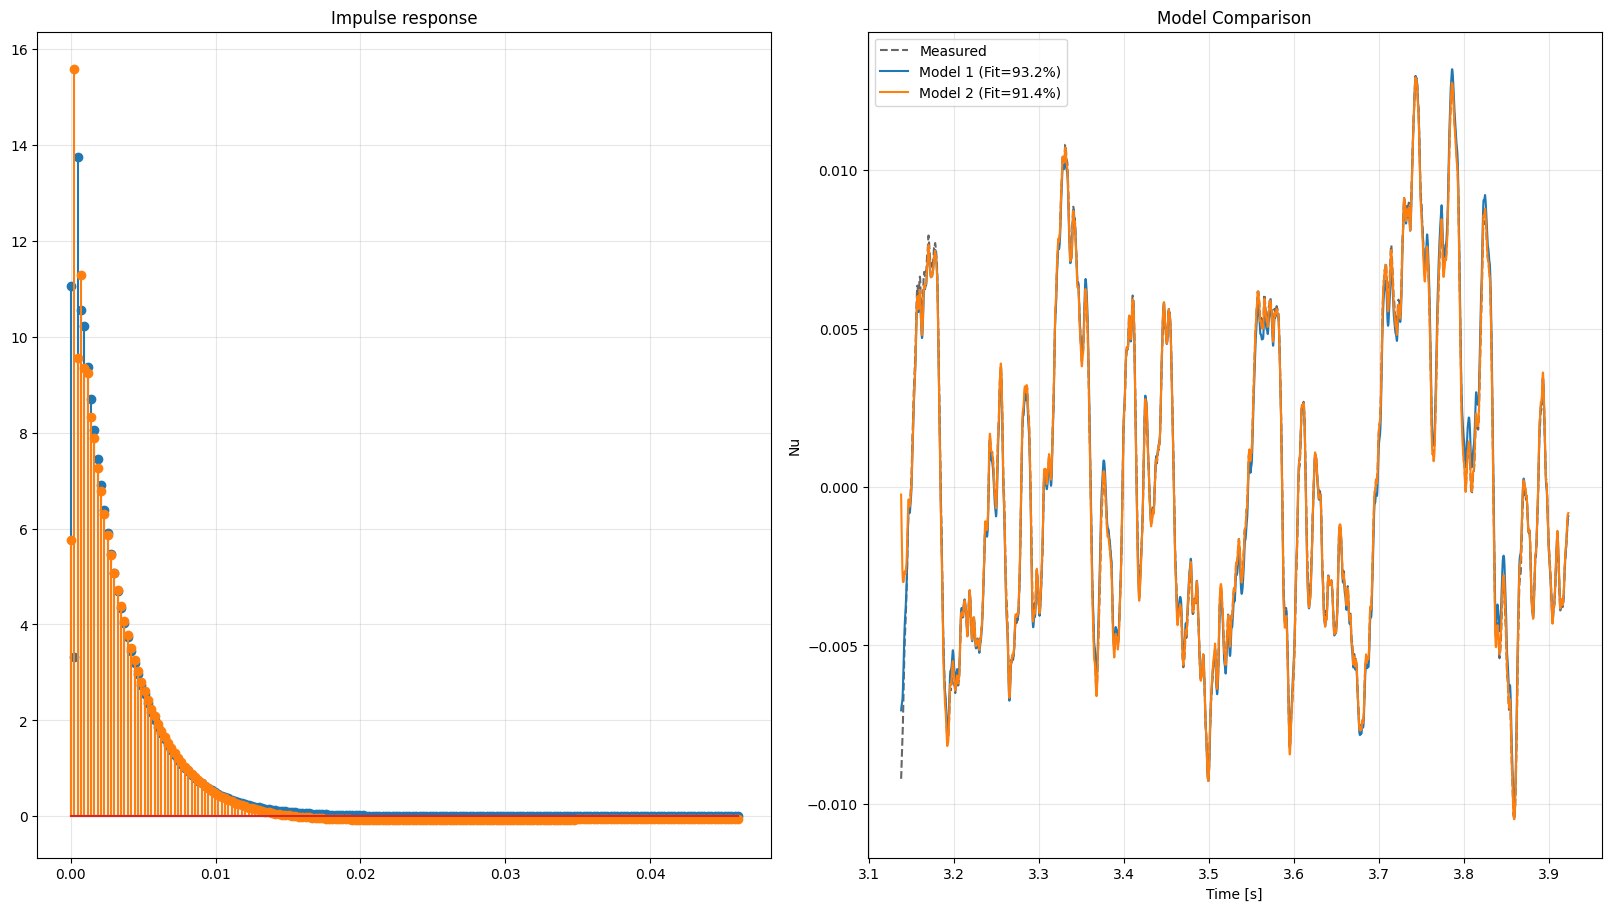

In [8]:
with llsi.Figure() as fig:
    mod1 = llsi.sysid(
        data, "Nu", "Re", (0, 100, 0), method="arx", settings={"lambda": 1e2}
    )
    mod1 = llsi.sysid(data, "Nu", "Re", 2, method="pem", settings={"init": "n4sid"})
    print("================")
    mod2 = llsi.sysid(
        data, "Nu", "Re", (3, 3, 0), method="pem", settings={"init": "arx"}
    )
    fig.plot([mod1, mod2], "impulse")
    fig.plot(
        {"mod": [mod1, mod2], "data": test_set, "y_name": "Nu", "u_name": "Re"},
        "compare",
    )

In [9]:
if False:
    import scipy

    t, y = scipy.signal.dimpulse(mod1.to_ss())

    fig, ax = plt.subplots()
    plt.plot(t, np.squeeze(y))
    plt.grid()
    plt.xlabel("n [samples]")
    plt.ylabel("Amplitude")

    t, y = scipy.signal.impulse(mod1.to_ss(continuous=True))

    # fig, ax = plt.subplots()
    plt.plot(t[1:], np.squeeze(y)[1:])
    plt.grid()
    plt.xlabel("n [samples]")
    plt.ylabel("Amplitude")

    t, y = scipy.signal.impulse(mod1.to_ss(continuous=True, method="euler"))

    # fig, ax = plt.subplots()
    plt.plot(t[1:], np.squeeze(y)[1:])
    plt.grid()
    plt.xlabel("n [samples]")
    plt.ylabel("Amplitude")

    t, y = scipy.signal.dimpulse(mod1.to_tf())
    plt.plot(t[1:], np.squeeze(y)[1:])
    plt.grid()
    plt.xlabel("n [samples]")
    plt.ylabel("Amplitude")

    t, y = scipy.signal.dimpulse(mod1.to_zpk())
    plt.plot(t[1:], np.squeeze(y)[1:])
    plt.grid()
    plt.xlabel("n [samples]")
    plt.ylabel("Amplitude")

    plt.legend(["discrete", "cont", "euler", "tf", "zpk"])

[[11.06498559]
 [ 3.32895304]
 [13.74186162]
 [10.55380714]
 [10.21514343]]


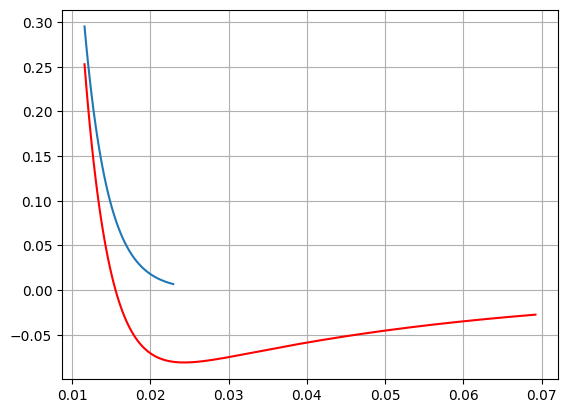

In [10]:
fig, ax = plt.subplots()
ti1, i1 = mod1.impulse_response()
ti2, i2 = mod2.impulse_response(300)
plt.plot(ti1[50:], i1[50:])
plt.plot(ti2[50:], i2[50:], "r")
plt.grid(True)

print(i1[:5])
# print(i2[:5])